**Data:**

Dataset: Chest X-Ray Images (Pneumonia), source: 
1. https://data.mendeley.com/datasets/rscbjbr9sj/3


First I manually split the Pneumonia folders in both the train and the validation set in two seperate folders: 'BACTERIAL PNEUMONIA', 'VIRAL PNEUMONIA'. 

**Requirements:**

In [20]:
from google.colab import drive
drive.mount('/content/gdrive', force_remount=True)
root_dir = "/content/gdrive/My Drive/"

Mounted at /content/gdrive


In [0]:
from fastai.vision import *
from fastai.metrics import error_rate
import numpy as np
import pandas as pd 
import os
import matplotlib.pyplot as plt

In [0]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [0]:
import warnings
warnings.filterwarnings("ignore", category=UserWarning, module="torch.nn.functional")

In [0]:
#conda install -c fastai fastai

In [0]:
#!pip install "torch==1.4" "torchvision==0.5.0"

In [0]:
#np.random.seed(40)

**Data:**


In [8]:
path = Path(root_dir + 'Datasets/chest_xray_v3')
path.ls()

[PosixPath('/content/gdrive/My Drive/Datasets/chest_xray_v3/.DS_Store'),
 PosixPath('/content/gdrive/My Drive/Datasets/chest_xray_v3/train'),
 PosixPath('/content/gdrive/My Drive/Datasets/chest_xray_v3/valid'),
 PosixPath('/content/gdrive/My Drive/Datasets/chest_xray_v3/models')]

In [0]:
bs = 128

In [0]:
tfms = get_transforms(do_flip=False, max_rotate=30., max_zoom=1.1, max_lighting= 0.1, max_warp=0.1)

In [0]:
src = (ImageList.from_folder(path)     
        .split_by_folder(train='train', valid='valid')              
        .label_from_folder())            

In [0]:
data = (src.transform(tfms, size=(128,128))       
        .databunch(bs=bs)
        .normalize(imagenet_stats))  

In [12]:
data.classes, data.c, len(data.train_ds), len(data.valid_ds)

NameError: ignored

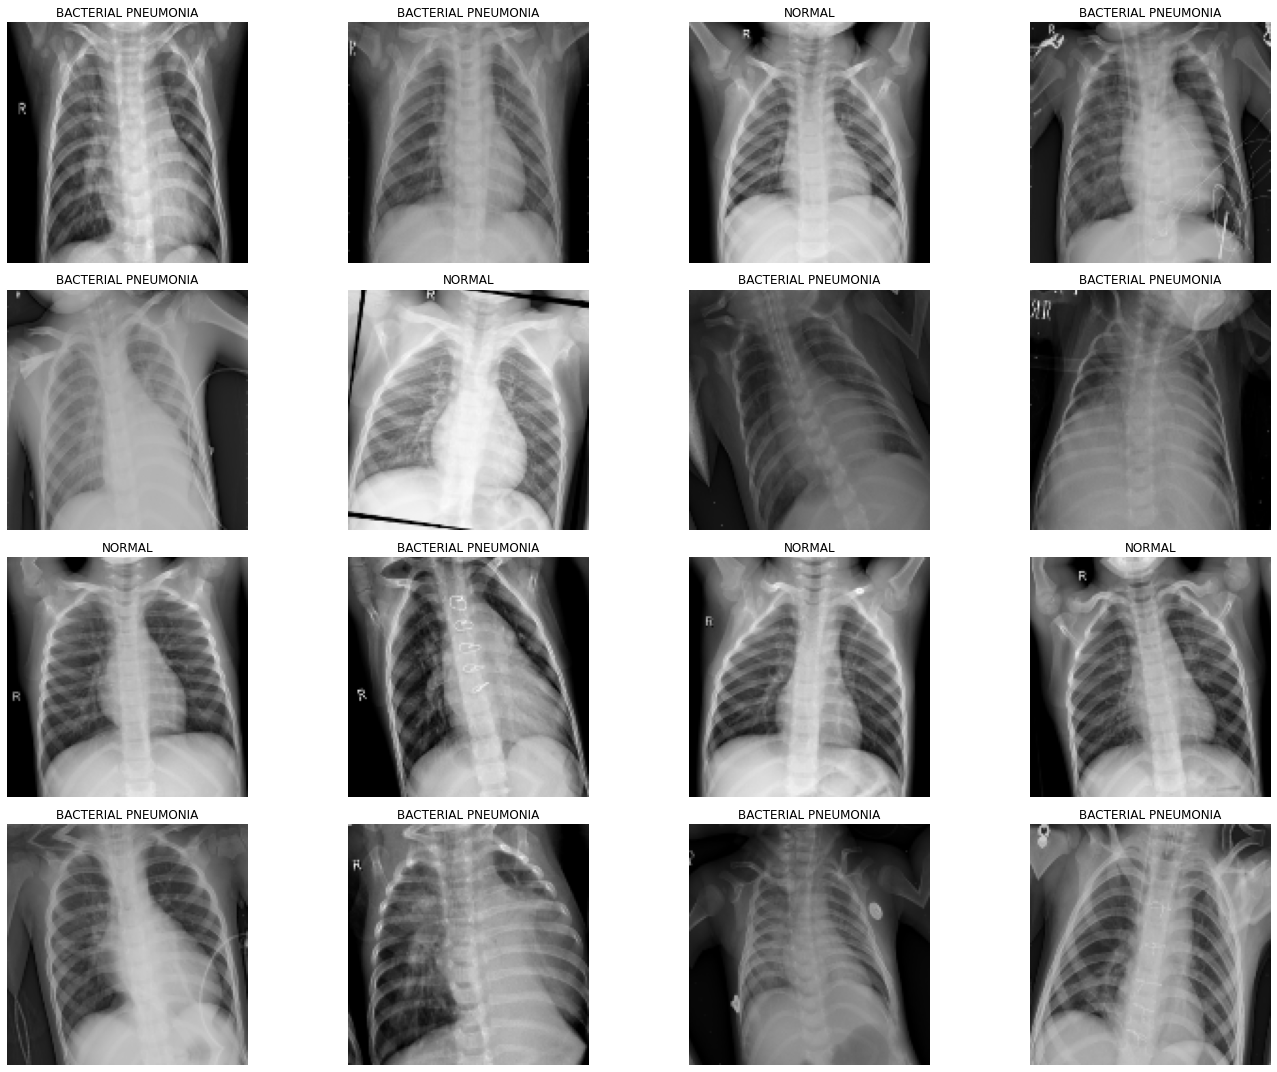

In [0]:
data.show_batch(rows=4, figsize=(20,15))

**Model:**

In [0]:
learn = cnn_learner(data, models.resnet18, wd=0.1, metrics=error_rate)

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


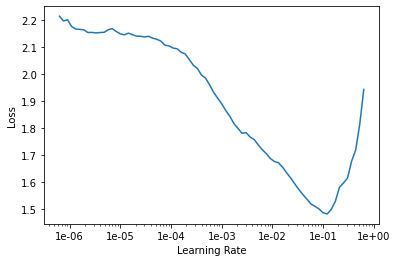

In [14]:
learn.lr_find()
learn.recorder.plot()

In [0]:
lr = 1e-3

In [17]:
learn.fit_one_cycle(10, slice(lr))

epoch,train_loss,valid_loss,error_rate,time
0,1.584840,1.114788,0.439103,02:31
1,1.228611,0.735990,0.248397,02:32
2,1.013449,0.688592,0.240385,02:30
3,0.900653,0.695512,0.243590,02:28
4,0.796579,0.659385,0.240385,02:29
5,0.718156,0.681504,0.245192,02:30
6,0.671980,0.641795,0.233974,02:30
7,0.646908,0.632608,0.219551,02:35
8,0.625363,0.610384,0.216346,02:35
9,0.616415,0.628735,0.224359,02:34


In [0]:
learn.save('stage-1-128-rn18')

**Fine Tuning:**

In [21]:
learn.load('stage-1-128-rn18')

interp = ClassificationInterpretation.from_learner(learn)

losses,idxs = interp.top_losses()

len(data.valid_ds)==len(losses)==len(idxs)

True

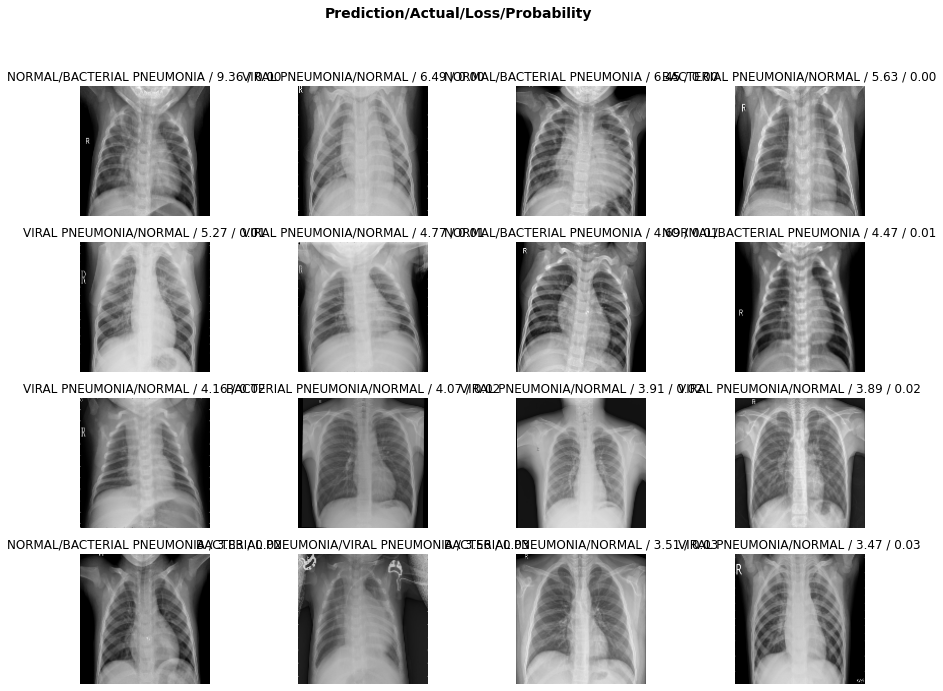

In [22]:
interp.plot_top_losses(16, figsize=(15,11))

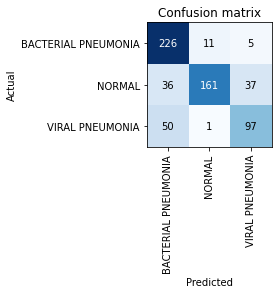

In [23]:
interp.plot_confusion_matrix()

In [0]:
learn.unfreeze()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


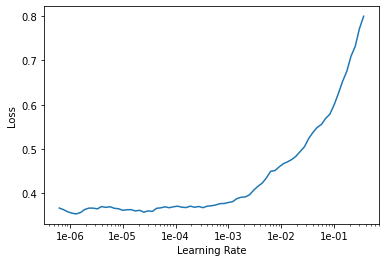

In [30]:
learn.lr_find()
learn.recorder.plot()

In [31]:
learn.fit_one_cycle(5, slice(1e-5,lr/10))

epoch,train_loss,valid_loss,error_rate,time
0,0.368047,0.381858,0.116987,02:30
1,0.367293,0.383576,0.116987,02:31
2,0.354936,0.370632,0.108974,02:31
3,0.336648,0.390155,0.123397,02:32
4,0.333716,0.395968,0.126603,02:32


In [0]:
learn.save('stage-2-128-rn18')

In [13]:
learn.load('stage-2-128-rn18')

interp = ClassificationInterpretation.from_learner(learn)

losses,idxs = interp.top_losses()

len(data.valid_ds)==len(losses)==len(idxs)

interp.plot_confusion_matrix()

NameError: ignored

**Further training on larger images:**

In [0]:
data = (src.transform(tfms, size=(256,256))       
        .databunch(bs=bs//2)
        .normalize(imagenet_stats))  


In [0]:
learn.data = data

In [0]:
learn.freeze()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


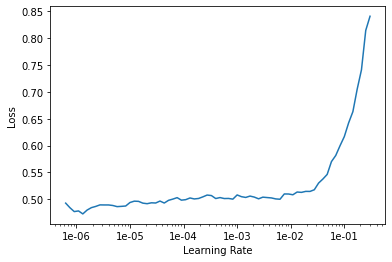

In [25]:
learn.lr_find()
learn.recorder.plot()

In [0]:
lr= 1e-3

In [0]:
learn.fit_one_cycle(5, slice(lr))

epoch,train_loss,valid_loss,error_rate,time


In [0]:
learn.save('stage-1-256-rn18')

In [24]:
learn.load('stage-1-256-rn18')

Learner(data=ImageDataBunch;

Train: LabelList (5232 items)
x: ImageList
Image (3, 256, 256),Image (3, 256, 256),Image (3, 256, 256),Image (3, 256, 256),Image (3, 256, 256)
y: CategoryList
NORMAL,NORMAL,NORMAL,NORMAL,NORMAL
Path: /content/gdrive/My Drive/Datasets/chest_xray_v3;

Valid: LabelList (624 items)
x: ImageList
Image (3, 256, 256),Image (3, 256, 256),Image (3, 256, 256),Image (3, 256, 256),Image (3, 256, 256)
y: CategoryList
NORMAL,NORMAL,NORMAL,NORMAL,NORMAL
Path: /content/gdrive/My Drive/Datasets/chest_xray_v3;

Test: None, model=Sequential(
  (0): Sequential(
    (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (4): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=Fal

In [0]:
learn.unfreeze()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


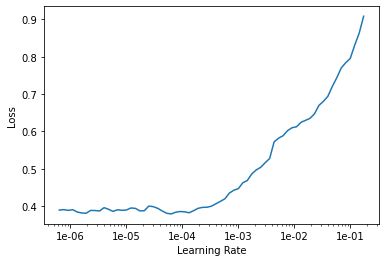

In [0]:
learn.lr_find()
learn.recorder.plot()

In [0]:
learn.fit_one_cycle(5, slice(1e-5, lr/5))

epoch,train_loss,valid_loss,error_rate,time
0,0.402200,0.561464,0.163462,04:18
1,0.413233,0.574385,0.157051,04:17
2,0.389223,0.622086,0.184295,04:20


KeyboardInterrupt: ignored

In [0]:
learn.save('stage-2-256-rn34')

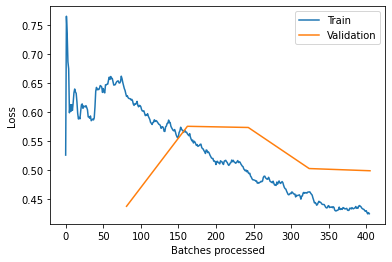

In [0]:
learn.recorder.plot_losses()

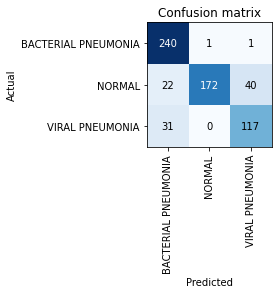

In [0]:
interp.plot_confusion_matrix()